In [1]:
import os
os.chdir("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from utils.data import Dataset
from utils.completer import complete_by_mean_col, complete_by_multi, complete_by_similar_row
from utils.generator import gen_complete_random

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

In [4]:
data_size = 1000
# target
Y = np.random.randint(0, 2, data_size)
Y = Y * 2 - 1

In [5]:
# protected attribute dependent on target to produce bias
YP_corr = 0.8
rnd_vec = np.random.randn(data_size)
P = YP_corr * (Y / np.linalg.norm(Y)) + (1-YP_corr**2)**0.5 * (rnd_vec / np.linalg.norm(rnd_vec))
P = np.where(P <= 0, P, 1)
P = np.where(P > 0, P, -1)

In [6]:
np.corrcoef(Y, P)

array([[1.        , 0.82169557],
       [0.82169557, 1.        ]])

In [7]:
# 3 clusters dependent on target
center0 = (0, 0) # target 0
center1 = (0, 15) # target 1
center2 = (15, 0) # target 1
Y_unique = np.unique(Y, return_counts=True)
Y0_size = Y_unique[1][np.where(Y_unique[0] == -1)][0]
Y1_size = Y_unique[1][np.where(Y_unique[0] == 1)][0]
X_cluster0 = np.array([*center0]) + 3.0 * np.random.randn(Y0_size, 2)
X_cluster1 = np.array([*center1]) + 3.0 * np.random.randn(Y1_size//3, 2)
X_cluster2 = np.array([*center2]) + 3.0 * np.random.randn(Y1_size-Y1_size//3, 2)
X_cluster12 = np.concatenate([X_cluster1, X_cluster2], axis=0)
np.random.shuffle(X_cluster12)
X = np.concatenate([X_cluster0, X_cluster12], axis=0)
YP = np.stack([P, Y]).T
YP = YP[YP[:, 1].argsort()]
XY = np.concatenate([X, YP], axis=1)
np.random.shuffle(XY)
X = XY[:, :-1]
Y = XY[:, -1]

In [8]:
X.shape

(1000, 3)

In [9]:
np.corrcoef(X[:,0], X[:,2])

array([[1.        , 0.54291476],
       [0.54291476, 1.        ]])

In [10]:
np.corrcoef(X[:,1], X[:,2])

array([[1.        , 0.29526738],
       [0.29526738, 1.        ]])

In [11]:
Y.shape

(1000,)

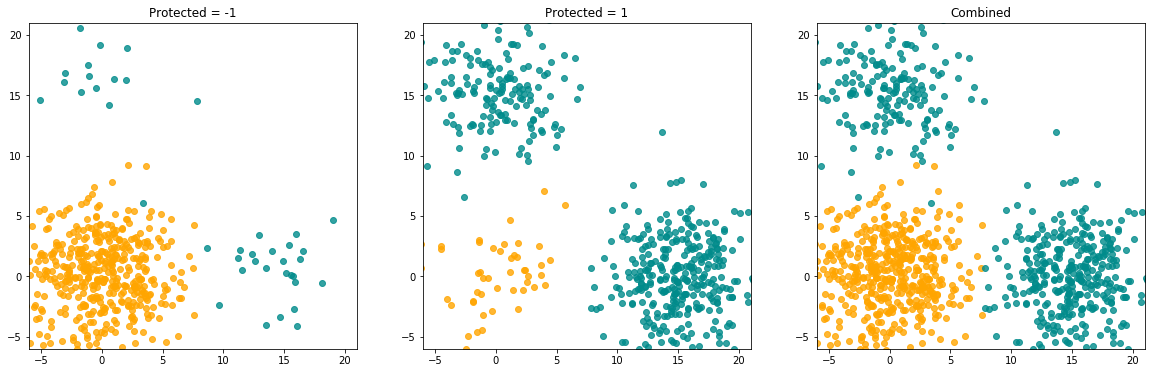

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plotData = np.concatenate([X, Y.reshape(-1, 1)], axis=1)
plotX1 = plotData[np.where(plotData[:, 2] == -1)]
plotX2 = plotData[np.where(plotData[:, 2] == 1)]
axes[0].scatter(plotX1[np.where(plotX1[:, -1] == -1)][:, 0], plotX1[np.where(plotX1[:, -1] == -1)][:, 1], c="orange", alpha=0.8)
axes[0].scatter(plotX1[np.where(plotX1[:, -1] == 1)][:, 0], plotX1[np.where(plotX1[:, -1] == 1)][:, 1], c="darkcyan", alpha=0.8)
axes[0].set_xlim([-6, 21])
axes[0].set_ylim([-6, 21])
axes[0].set_title("Protected = -1")
axes[1].scatter(plotX2[np.where(plotX2[:, -1] == -1)][:, 0], plotX2[np.where(plotX2[:, -1] == -1)][:, 1], c="orange", alpha=0.8)
axes[1].scatter(plotX2[np.where(plotX2[:, -1] == 1)][:, 0], plotX2[np.where(plotX2[:, -1] == 1)][:, 1], c="darkcyan", alpha=0.8)
axes[1].set_xlim([-6, 21])
axes[1].set_ylim([-6, 21])
axes[1].set_title("Protected = 1")
axes[2].scatter(plotData[np.where(plotData[:, -1] == -1)][:, 0], plotData[np.where(plotData[:, -1] == -1)][:, 1], c="orange", alpha=0.8)
axes[2].scatter(plotData[np.where(plotData[:, -1] == 1)][:, 0], plotData[np.where(plotData[:, -1] == 1)][:, 1], c="darkcyan", alpha=0.8)
axes[2].set_xlim([-6, 21])
axes[2].set_ylim([-6, 21])
axes[2].set_title("Combined")
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.98

In [14]:
data = Dataset("test", pd.DataFrame(X, columns=list("ABC")), Y, protected_features=["C"])

In [15]:
data_miss = gen_complete_random(data, random_ratio=0.2)

gen_complete_random: 448 NaN values have been inserted


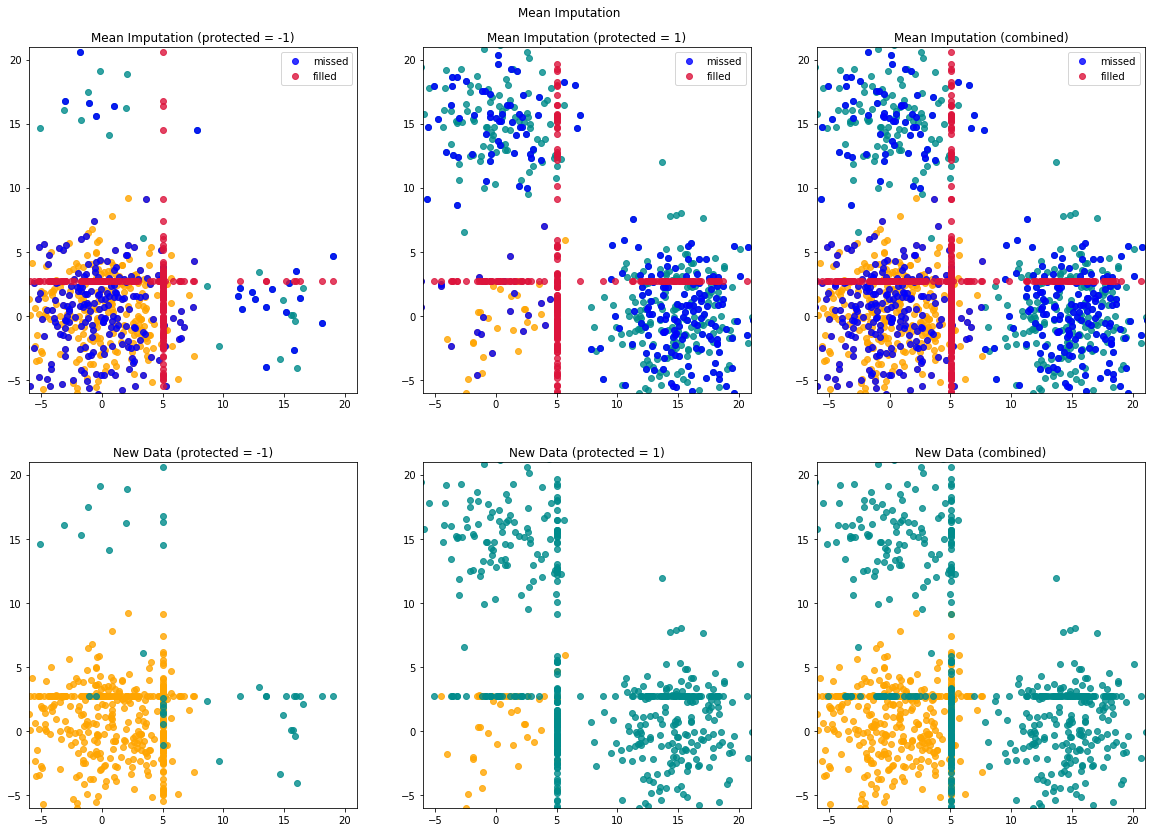

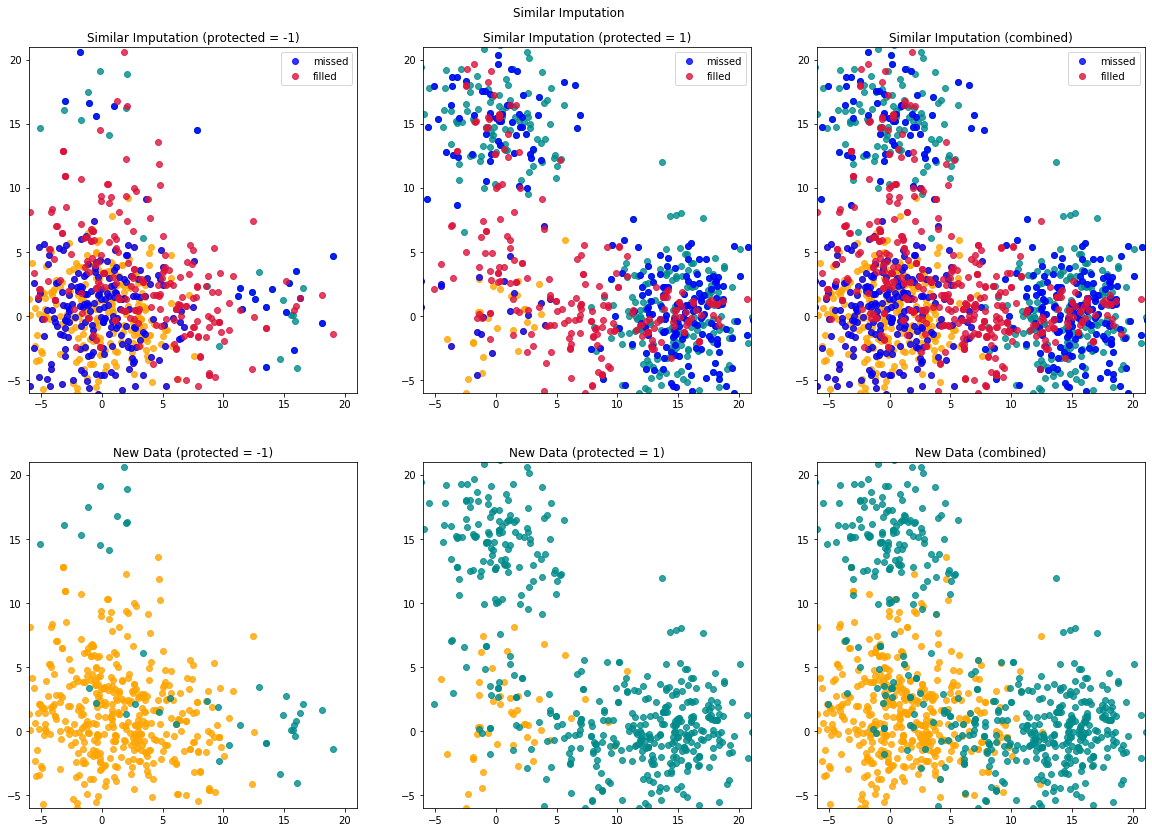

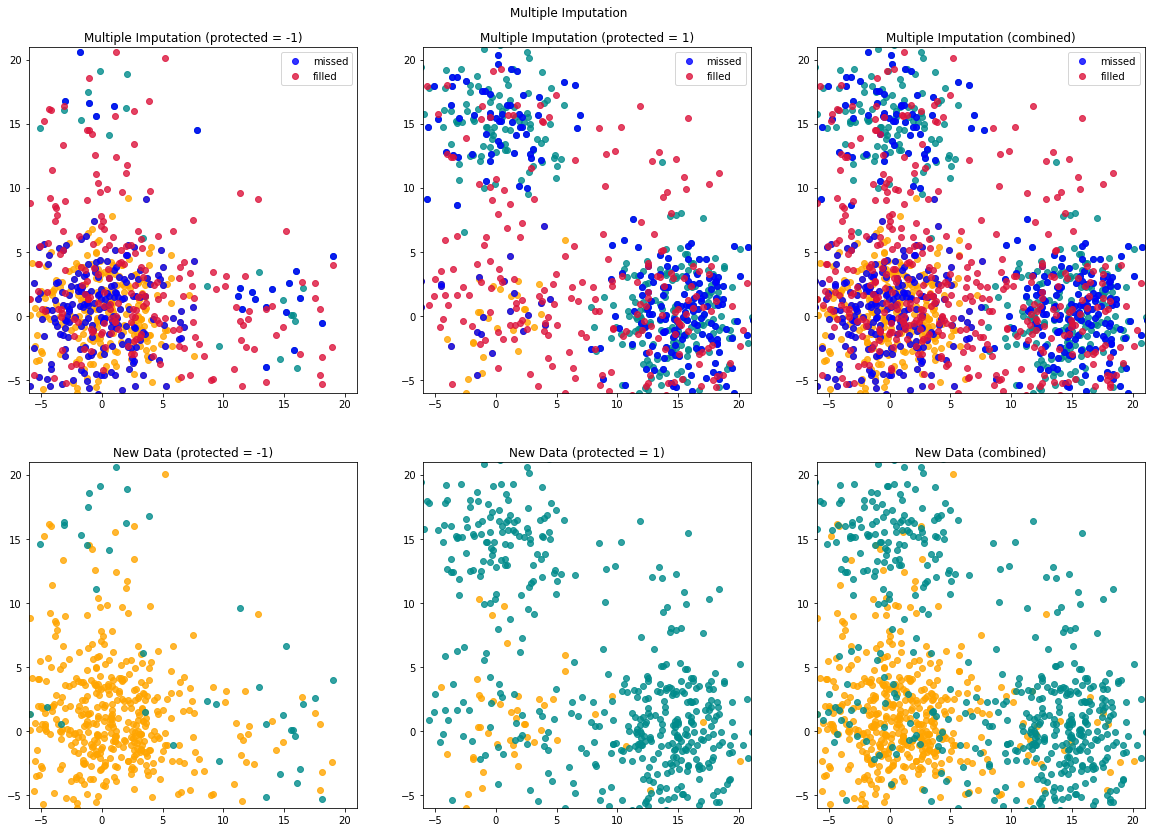

In [16]:
idx_miss = data_miss.X.isnull().sum(axis=1).to_numpy()
methods = {
    "Mean Imputation": complete_by_mean_col,
    "Similar Imputation": complete_by_similar_row,
    "Multiple Imputation": complete_by_multi,
}
for name, method_fn in methods.items():
    data_complete = method_fn(data_miss)
    if name == "Multiple Imputation": data_complete = data_complete[0]
    data_complete = data_complete.X.to_numpy()
    plotDataOrig = np.concatenate([X, Y.reshape(-1, 1)], axis=1)
    plotDataNew = np.concatenate([data_complete, Y.reshape(-1, 1), idx_miss.reshape(-1, 1)], axis=1)
    plotX1Orig = plotDataOrig[np.where(plotDataOrig[:, 2] == -1)]
    plotX2Orig = plotDataOrig[np.where(plotDataOrig[:, 2] == 1)]
    plotX1New = plotDataNew[np.where(plotDataNew[:, 2] == -1)]
    plotX2New = plotDataNew[np.where(plotDataNew[:, 2] == 1)]
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    axes[0, 0].scatter(plotX1Orig[np.where(plotX1Orig[:, -1] == -1)][:, 0], plotX1Orig[np.where(plotX1Orig[:, -1] == -1)][:, 1], c="orange", alpha=0.8)
    axes[0, 0].scatter(plotX1Orig[np.where(plotX1Orig[:, -1] == 1)][:, 0], plotX1Orig[np.where(plotX1Orig[:, -1] == 1)][:, 1], c="darkcyan", alpha=0.8)
    axes[0, 0].scatter(plotX1Orig[np.where(plotX1New[:, -1] > 0)][:, 0], plotX1Orig[np.where(plotX1New[:, -1] > 0)][:, 1], c="blue", label="missed", alpha=0.8)
    axes[0, 0].scatter(plotX1New[np.where(plotX1New[:, -1] > 0)][:, 0], plotX1New[np.where(plotX1New[:, -1] > 0)][:, 1], c="crimson", label="filled", alpha=0.8)
    axes[0, 0].set_title(name + " (protected = -1)")
    axes[0, 0].set_xlim([-6, 21])
    axes[0, 0].set_ylim([-6, 21])
    axes[0, 0].legend(loc="best")
    axes[1, 0].scatter(plotX1New[np.where(plotX1New[:, 3] == -1)][:, 0], plotX1New[np.where(plotX1New[:, 3] == -1)][:, 1], c="orange", alpha=0.8)
    axes[1, 0].scatter(plotX1New[np.where(plotX1New[:, 3] == 1)][:, 0], plotX1New[np.where(plotX1New[:, 3] == 1)][:, 1], c="darkcyan", alpha=0.8)
    axes[1, 0].set_title("New Data (protected = -1)")
    axes[1, 0].set_xlim([-6, 21])
    axes[1, 0].set_ylim([-6, 21])
    
    axes[0, 1].scatter(plotX2Orig[np.where(plotX2Orig[:, -1] == -1)][:, 0], plotX2Orig[np.where(plotX2Orig[:, -1] == -1)][:, 1], c="orange", alpha=0.8)
    axes[0, 1].scatter(plotX2Orig[np.where(plotX2Orig[:, -1] == 1)][:, 0], plotX2Orig[np.where(plotX2Orig[:, -1] == 1)][:, 1], c="darkcyan", alpha=0.8)
    axes[0, 1].scatter(plotX2Orig[np.where(plotX2New[:, -1] > 0)][:, 0], plotX2Orig[np.where(plotX2New[:, -1] > 0)][:, 1], c="blue", label="missed", alpha=0.8)
    axes[0, 1].scatter(plotX2New[np.where(plotX2New[:, -1] > 0)][:, 0], plotX2New[np.where(plotX2New[:, -1] > 0)][:, 1], c="crimson", label="filled", alpha=0.8)
    axes[0, 1].set_title(name + " (protected = 1)")
    axes[0, 1].set_xlim([-6, 21])
    axes[0, 1].set_ylim([-6, 21])
    axes[0, 1].legend(loc="best")
    axes[1, 1].scatter(plotX2New[np.where(plotX2New[:, 3] == -1)][:, 0], plotX2New[np.where(plotX2New[:, 3] == -1)][:, 1], c="orange", alpha=0.8)
    axes[1, 1].scatter(plotX2New[np.where(plotX2New[:, 3] == 1)][:, 0], plotX2New[np.where(plotX2New[:, 3] == 1)][:, 1], c="darkcyan", alpha=0.8)
    axes[1, 1].set_title("New Data (protected = 1)")
    axes[1, 1].set_xlim([-6, 21])
    axes[1, 1].set_ylim([-6, 21])
    
    axes[0, 2].scatter(plotDataOrig[np.where(plotDataOrig[:, -1] == -1)][:, 0], plotDataOrig[np.where(plotDataOrig[:, -1] == -1)][:, 1], c="orange", alpha=0.8)
    axes[0, 2].scatter(plotDataOrig[np.where(plotDataOrig[:, -1] == 1)][:, 0], plotDataOrig[np.where(plotDataOrig[:, -1] == 1)][:, 1], c="darkcyan", alpha=0.8)
    axes[0, 2].scatter(plotDataOrig[np.where(plotDataNew[:, -1] > 0)][:, 0], plotDataOrig[np.where(plotDataNew[:, -1] > 0)][:, 1], c="blue", label="missed", alpha=0.8)
    axes[0, 2].scatter(plotDataNew[np.where(plotDataNew[:, -1] > 0)][:, 0], plotDataNew[np.where(plotDataNew[:, -1] > 0)][:, 1], c="crimson", label="filled", alpha=0.8)
    axes[0, 2].set_title(name + " (combined)")
    axes[0, 2].set_xlim([-6, 21])
    axes[0, 2].set_ylim([-6, 21])
    axes[0, 2].legend(loc="best")
    axes[1, 2].scatter(plotDataNew[np.where(plotDataNew[:, 3] == -1)][:, 0], plotDataNew[np.where(plotDataNew[:, 3] == -1)][:, 1], c="orange", alpha=0.8)
    axes[1, 2].scatter(plotDataNew[np.where(plotDataNew[:, 3] == 1)][:, 0], plotDataNew[np.where(plotDataNew[:, 3] == 1)][:, 1], c="darkcyan", alpha=0.8)
    axes[1, 2].set_title("New Data (combined)")
    axes[1, 2].set_xlim([-6, 21])
    axes[1, 2].set_ylim([-6, 21])
    
    fig.suptitle(name, y=0.92)
    plt.show()

$$
\begin{aligned}
\text{Bias} &= |\text{FPR}_A - \text{FPR}_B| + |\text{FNR}_A - \text{FNR}_B| \\
            &= \Big|\frac{\text{FP}_A}{\text{FP}_A+\text{TN}_A}-\frac{\text{FP}_B}{\text{FP}_B+\text{TN}_B}\Big| +
               \Big|\frac{\text{FN}_A}{\text{FN}_A+\text{TP}_A}-\frac{\text{FN}_B}{\text{FN}_B+\text{TP}_B}\Big|
\end{aligned}
$$

In [17]:
def newBias(data, A=1, B=1):
    # Pr(AA is labeled as low risk when he is actually high risk) = Pr(Caucasian is labeled as low risk when actually high risk) 
    # Pr(AA is labeled as high risk when he is low risk) =  Pr(Caucasian is labeled as high risk when actually low risk)
    # bias = |LHS - RHS|
    # A*|LHS - RHS of first type| + B*|LHS - RHS of second type|
    # A*|FPR_A - FPR_B| + B*|FNR_A - FNR_C|
    FPR_A = data[1] / (data[1] + data[0])
    FNR_A = data[2] / (data[2] + data[3])
    FPR_B  = data[5] / (data[5] + data[4])
    FNR_B  = data[6] / (data[6] + data[7])
    bias = A*abs(FPR_A - FPR_B) + B*abs(FNR_A - FNR_B)
    return bias

In [18]:
def helper_freq(array):
    """simple helper function to return the most frequent number in an array"""
    count = np.bincount(array)
    return array[np.argmax(count)]

In [19]:
# original bias
bias_orig = 0.0
acc_orig = 0.0
for train_idx, test_idx in StratifiedShuffleSplit(n_splits=5).split(X, Y):
    X_train, X_test = data.X.iloc[train_idx], data.X.iloc[test_idx]
    Y_train, Y_test = data.y[train_idx], data.y[test_idx]
    X_train.reset_index(drop=True, inplace=True)
    X_train = X_train.drop(columns=["C"])
    X_test.reset_index(drop=True, inplace=True)
    smote = SMOTE()
    scaler = StandardScaler()
    X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train)
    X_scaled = scaler.fit_transform(X_train_res)
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_scaled, Y_train_res)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test.drop(columns=["C"])), columns=X_test.drop(columns=["C"]).columns)
    X_test_scaled = pd.concat([X_test_scaled, X_test["C"]], axis=1)
    X_test_A = X_test_scaled[X_test_scaled["C"] == -1].drop(columns=["C"]).to_numpy()
    X_test_B = X_test_scaled[X_test_scaled["C"] == 1].drop(columns=["C"]).to_numpy()
    Y_test_A = Y_test[X_test_scaled[X_test_scaled["C"] == -1].index.tolist()]
    Y_test_B = Y_test[X_test_scaled[X_test_scaled["C"] == 1].index.tolist()]
    matrix_A = confusion_matrix(Y_test_A, clf.predict(X_test_A)).ravel().tolist()
    matrix_B = confusion_matrix(Y_test_B, clf.predict(X_test_B)).ravel().tolist()
    print(matrix_A + matrix_B)
    bias_orig += newBias(matrix_A+matrix_B)
    acc_orig += clf.score(X_test_scaled.drop(columns=["C"]).to_numpy(), Y_test)
bias_orig /= 5
acc_orig /= 5
bias_orig, acc_orig

[43, 0, 0, 4, 5, 0, 2, 46]
[39, 1, 0, 5, 7, 1, 5, 42]
[42, 3, 0, 5, 3, 0, 2, 45]
[42, 1, 0, 5, 4, 1, 3, 44]
[42, 0, 0, 3, 6, 0, 4, 45]


(0.13589522597757558, 0.9540000000000001)

In [20]:
def test(X_data, Y_data):
    missingness = np.linspace(0.0, 0.5, 50)
    plot_bias = []
    plot_acc = []
    for miss_ratio in missingness.tolist():
        bias = []
        acc = []
        print("Missing Ratio: {:.4f}".format(miss_ratio))
        complete_data = Dataset("test", pd.DataFrame(X_data, columns=list("ABC")), Y_data, protected_features=["C"])
        missing_data = gen_complete_random(complete_data, random_ratio=miss_ratio, print_all=False)

        for train_idx, test_idx in StratifiedShuffleSplit(n_splits=10).split(missing_data.X, missing_data.y):
            X_train, X_test = missing_data.X.iloc[train_idx], missing_data.X.iloc[test_idx]
            Y_train, Y_test = missing_data.y[train_idx], missing_data.y[test_idx]
            X_train.reset_index(drop=True, inplace=True)
            X_test.reset_index(drop=True, inplace=True)

            data_incomplete = Dataset("tmp", X_train, Y_train, types=missing_data.types, 
                protected_features=missing_data.protected_features, categorical_features=missing_data.categorical_features,
                encoders=[missing_data.X_encoders, missing_data.y_encoder])
            data_complete = complete_by_mean_col(data_incomplete)
            X_train = data_complete.X.drop(columns=missing_data.protected_features)
            Y_train = data_complete.y

            data_incomplete = Dataset("tmp", X_test, Y_test, types=missing_data.types, 
                protected_features=missing_data.protected_features, categorical_features=missing_data.categorical_features,
                encoders=[missing_data.X_encoders, missing_data.y_encoder])
            data_complete = complete_by_mean_col(data_incomplete)
            X_test = data_complete.X
            Y_test = data_complete.y

            smote = SMOTE()
            scaler = StandardScaler()
            X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train)
            X_scaled = scaler.fit_transform(X_train_res)
            clf = LogisticRegression(max_iter=10000)
            clf.fit(X_scaled, Y_train_res)
            X_test_scaled = pd.DataFrame(scaler.transform(X_test.drop(columns=["C"])), columns=X_test.drop(columns=["C"]).columns)
            X_test_scaled = pd.concat([X_test_scaled, X_test["C"]], axis=1)
            X_test_A = X_test_scaled[X_test_scaled["C"] == -1].drop(columns=["C"]).to_numpy()
            X_test_B = X_test_scaled[X_test_scaled["C"] == 1].drop(columns=["C"]).to_numpy()
            Y_test_A = Y_test[X_test_scaled[X_test_scaled["C"] == -1].index.tolist()]
            Y_test_B = Y_test[X_test_scaled[X_test_scaled["C"] == 1].index.tolist()]
            matrix_A = confusion_matrix(Y_test_A, clf.predict(X_test_A)).ravel().tolist()
            matrix_B = confusion_matrix(Y_test_B, clf.predict(X_test_B)).ravel().tolist()
            print("\t{}".format(matrix_A + matrix_B))
            try:
                bias.append(newBias(matrix_A+matrix_B))
            except Exception as e:
                print("\tError: {}, data skipped".format(e))
            acc.append(accuracy_score(clf.predict(X_test_scaled.drop(columns=["C"]).to_numpy()), Y_test))
        plot_acc.append(np.mean(acc))
        plot_bias.append(np.mean(bias))
        print("Bias = {:.4f}".format(np.mean(bias)))
        print("Accuracy = {:.4f}".format(np.mean(acc)))
        print()
    
    plot_bias = np.array(plot_bias)
    plot_acc = np.array(plot_acc)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    axes[0, 0].plot(missingness, plot_bias)
    axes[0, 0].set_xlabel("Missing Ratio")
    axes[0, 0].set_title("Bias")

    axes[0, 1].plot(missingness, plot_acc)
    axes[0, 1].set_xlabel("Missing Ratio")
    axes[0, 1].set_title("Accuracy")
    
    axes[1, 0].scatter(plot_acc, plot_bias)
    axes[1, 0].set_xlabel("Accuracy")
    axes[1, 0].set_ylabel("Bias")
    axes[1, 0].set_title("Bias-Accuracy Relation")
    
    lr = LinearRegression(fit_intercept=True, normalize=False)
    lr.fit(plot_acc.reshape(-1, 1), np.log(plot_bias))
    prediction = lr.predict(plot_acc.reshape((-1, 1)))
    residual = np.mean(np.power((prediction - np.log(plot_bias)), 2))
    lam = lr.coef_[0]
    k = np.exp(lr.intercept_)
    xvec = np.linspace(0.0, 1.0, 1000)
    axes[1, 1].plot(xvec, k*np.exp(lam*xvec))
    axes[1, 1].set_xlabel("Accuracy")
    axes[1, 1].set_ylabel("Bias")
    axes[1, 1].set_title("k={:.4f}, lambda={:.4f}, error={:.4f}".format(k, lam, residual))
    
    plt.show()

Missing Ratio: 0.0000
	[42, 0, 1, 3, 6, 0, 2, 46]
	[45, 2, 0, 4, 1, 0, 5, 43]
	[44, 0, 0, 4, 4, 0, 1, 47]
	[41, 0, 0, 3, 7, 0, 1, 48]
	[39, 3, 0, 5, 6, 0, 1, 46]
	[41, 3, 0, 3, 4, 0, 0, 49]
	[46, 0, 0, 7, 2, 0, 1, 44]
	[41, 2, 1, 7, 5, 0, 1, 43]
	[41, 1, 1, 1, 6, 0, 1, 49]
	[41, 3, 0, 3, 4, 0, 2, 47]
Bias = 0.1341
Accuracy = 0.9680

Missing Ratio: 0.0102
	[41, 1, 0, 4, 6, 0, 5, 43]
	[46, 1, 0, 3, 1, 0, 6, 43]
	[44, 1, 0, 6, 3, 0, 5, 41]
	[41, 3, 0, 6, 4, 0, 2, 44]
	[44, 3, 0, 3, 1, 0, 4, 45]
	[45, 0, 0, 7, 2, 1, 7, 38]
	[41, 2, 0, 6, 5, 0, 2, 44]
	[44, 1, 1, 5, 3, 0, 5, 41]
	[39, 2, 0, 6, 7, 0, 3, 43]
	[40, 2, 0, 3, 6, 0, 6, 43]
Bias = 0.1603
Accuracy = 0.9370

Missing Ratio: 0.0204
	[42, 3, 0, 3, 3, 0, 8, 41]
	[46, 0, 1, 4, 2, 0, 7, 40]
	[43, 1, 0, 1, 4, 0, 7, 44]
	[39, 1, 0, 6, 8, 0, 7, 39]
	[44, 0, 0, 5, 4, 0, 8, 39]
	[37, 4, 1, 1, 7, 0, 6, 44]
	[42, 3, 0, 3, 3, 0, 4, 45]
	[39, 3, 1, 2, 4, 2, 3, 46]
	[41, 3, 0, 5, 4, 0, 4, 43]
	[40, 2, 0, 7, 5, 1, 3, 42]
Bias = 0.2287
Accuracy = 0.9

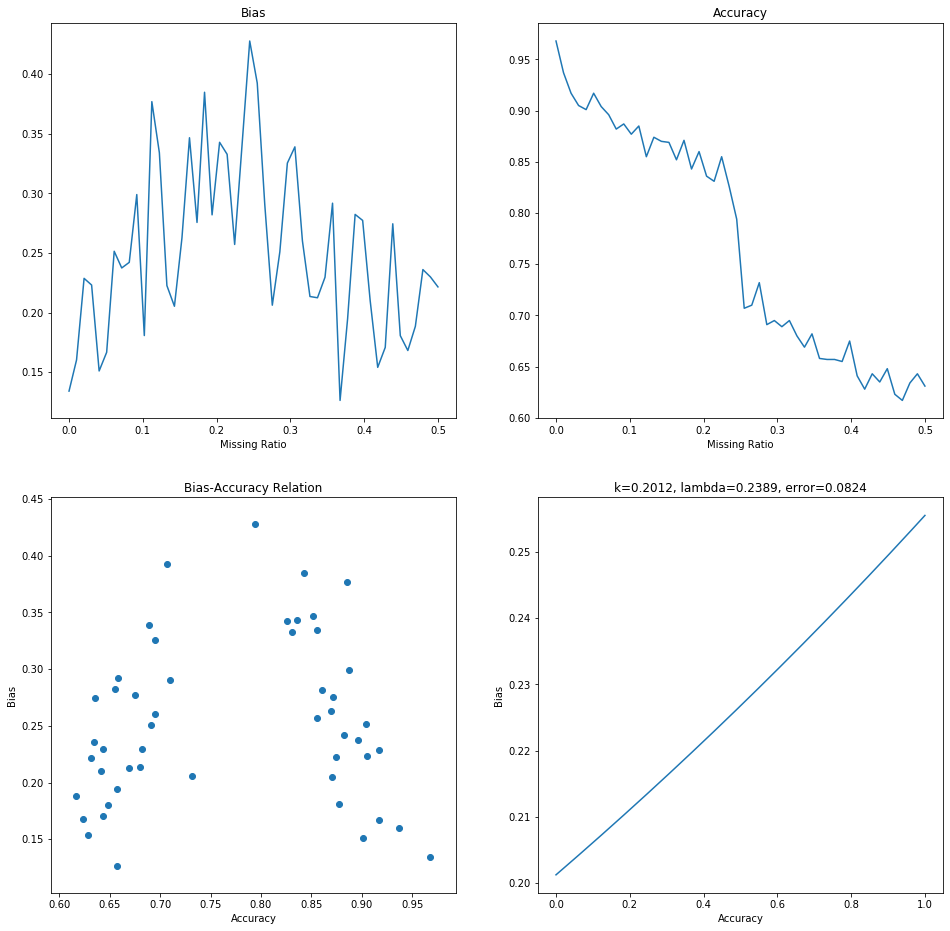

In [21]:
test(X.copy(), Y.copy())

### Observations  

| P Corr | Cluster 0 | Cluster 1 0 | Cluster 1 1 | Initial Bias | Initial Acc | k | $\lambda$ | $\frac{\sum\epsilon^2}{n}$ |
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| 0.2 | (0,0) | (0,15) | (15,0) | 0.06 | 0.97 | 0.1013 | 0.4061 | 0.0697 |
| 0.8 | (0,0) | (0,15) | (15,0) | 0.09 | 0.97 | 0.1265 | 0.7601 | 0.0724 |
| 0.2 | (5,5) | (0,15) | (15,0) | 0.14 | 0.81 | 0.1068 | 0.5662 | 0.0331 |
| 0.8 | (5,5) | (0,15) | (15,0) | 0.32 | 0.72 | 0.0788 | 2.2217 | 0.0435 |
| 0.2 | (0,15) | (0,15) | (15,0) | 0.18 | 0.83 | 0.084 | 0.8116 | 0.04 |
| 0.8 | (0,15) | (0,15) | (15,0) | 0.26 | 0.82 | 0.3138 | -0.1561 | 0.0663 |
| 0.2 | (15,0) | (0,15) | (15,0) | 0.24 | 0.62 | 0.0299 | 3.1174 | 0.0644 |
| 0.8 | (15,0) | (0,15) | (15,0) | 0.32 | 0.61 | 0.0609 | 2.9994 | 0.0338 |